# Questions II

In [69]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

On considère dans le modèle de Black & Scholes une option asiatique arithmétique discrète de maturité $T$ et de strike $K$. On pourra prendre comme valeurs de référence $S0 = 100, K = 100, T = 1, r = 0.05,  = 0.20, d = 12, N = 10^5$

---

## 1. Tracer en fonction de S0 sur un même graphe le prix exact du call européen et le prix Monte Carlo de l’option asiatique de mêmes strike et maturité à d dates. Commenter.

Avant de repondre la question, on va creer des fonctions utils pour les questions suivantes

In [81]:
##############################################################################
# COMMON IMPORTS AND FUNCTIONS
##############################################################################

def BS_Call_Price(S0, K, T, r, sigma):
    d1 = (np.log(S0/K) + (r + 0.5*sigma**2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S0*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def PayoffValuation(S, T, r, payoff):
    return np.exp(-r*T) * np.mean(payoff(S))

def GeneratePathsGBMEuler(NoOfPaths, NoOfSteps, T, r, sigma, S0):
    """
    Generate GBM paths using an Euler scheme with NoOfSteps steps between 0 and T.
    If NoOfSteps <= 0, we interpret that we only want S(0) and S(T),
    so we do a single 'exact' step from 0 to T.
    """
    if NoOfSteps <= 0:
        # Here d-1 = 0 => we have only 1 observation date (the final one at T).
        # Let's generate S(T) exactly for each path in one shot:
        Z = np.random.normal(0.0, 1.0, NoOfPaths)
        # GBM exact formula over [0, T]:
        # S(T) = S(0) * exp((r - 0.5 * sigma^2)*T + sigma * sqrt(T) * Z)
        ST = S0 * np.exp((r - 0.5*sigma*sigma)*T + sigma * np.sqrt(T) * Z)
        # We'll store the path array with shape (NoOfPaths, 2) 
        # so that the first column is time=0, the second column is time=T.
        S1 = np.zeros((NoOfPaths, 2))
        S1[:,0] = S0
        S1[:,1] = ST
        return {
            "time": np.array([0.0, T]),
            "S": S1
        }

    # If NoOfSteps > 0, proceed with the usual Euler scheme.
    Z = np.random.normal(0.0, 1.0, [NoOfPaths, NoOfSteps])
    W = np.zeros([NoOfPaths, NoOfSteps+1])
    S1 = np.zeros([NoOfPaths, NoOfSteps+1])
    S1[:, 0] = S0
    dt = T / float(NoOfSteps)
    
    for i in range(NoOfSteps):
        if NoOfPaths > 1:
            Z[:, i] = (Z[:, i] - np.mean(Z[:, i])) / np.std(Z[:, i])
        W[:, i+1] = W[:, i] + np.sqrt(dt)*Z[:, i]
        S1[:, i+1] = S1[:, i] + r*S1[:, i]*dt + sigma*S1[:, i]*(W[:, i+1] - W[:, i])

    time_grid = np.linspace(0, T, NoOfSteps+1)
    return {
        "time": time_grid,
        "S": S1
    }
    
    
def generate_paths_exact_bs_solution(no_of_paths, no_of_steps, T, r, sigma, S0):
    """
    Generate stock price paths using the exact solution of the Black-Scholes model.
    
    Parameters:
    no_of_paths (int): Number of simulated paths.
    no_of_steps (int): Number of time steps.
    T (float): Total time horizon (in years).
    r (float): Risk-free interest rate.
    sigma (float): Volatility of the underlying asset.
    S0 (float): Initial stock price.
    
    Returns:
    dict: A dictionary containing:
          - 'time': Array of time points.
          - 'S': Simulated stock price paths.
    """
    Z = np.random.normal(0.0, 1.0, [no_of_paths, no_of_steps])  # Random shocks
    S1 = np.zeros([no_of_paths, no_of_steps + 1])  # Stock prices
    S1[:, 0] = S0  # Initial stock price
    dt = T / float(no_of_steps)  # Time step size
    
    for i in range(no_of_steps):
        S1[:, i + 1] = S1[:, i] * np.exp((r - 0.5 * sigma**2) * dt + sigma * Z[:, i] * np.sqrt(dt))
    
    time_grid = np.linspace(0, T, no_of_steps + 1)
    return {
        "time": time_grid,
        "S": S1
    }

def confidence_interval(data, alpha=0.95):
    """
    Calculate the confidence interval for the mean of a given data set.
    
    Parameters:
    data (array-like): Data points for which the confidence interval is computed.
    alpha (float): Confidence level (default is 0.95 for a 95% confidence interval).
    
    Returns:
    tuple: A tuple containing:
           - mean_: The sample mean.
           - lower_bound: Lower bound of the confidence interval.
           - upper_bound: Upper bound of the confidence interval.
    """
    mean_ = np.mean(data)
    std_ = np.std(data, ddof=1)  # Use unbiased estimator for standard deviation
    n = len(data)
    z = norm.ppf(1 - (1 - alpha) / 2)
    delta = z * std_ / np.sqrt(n)
    return mean_, mean_ - delta, mean_ + delta

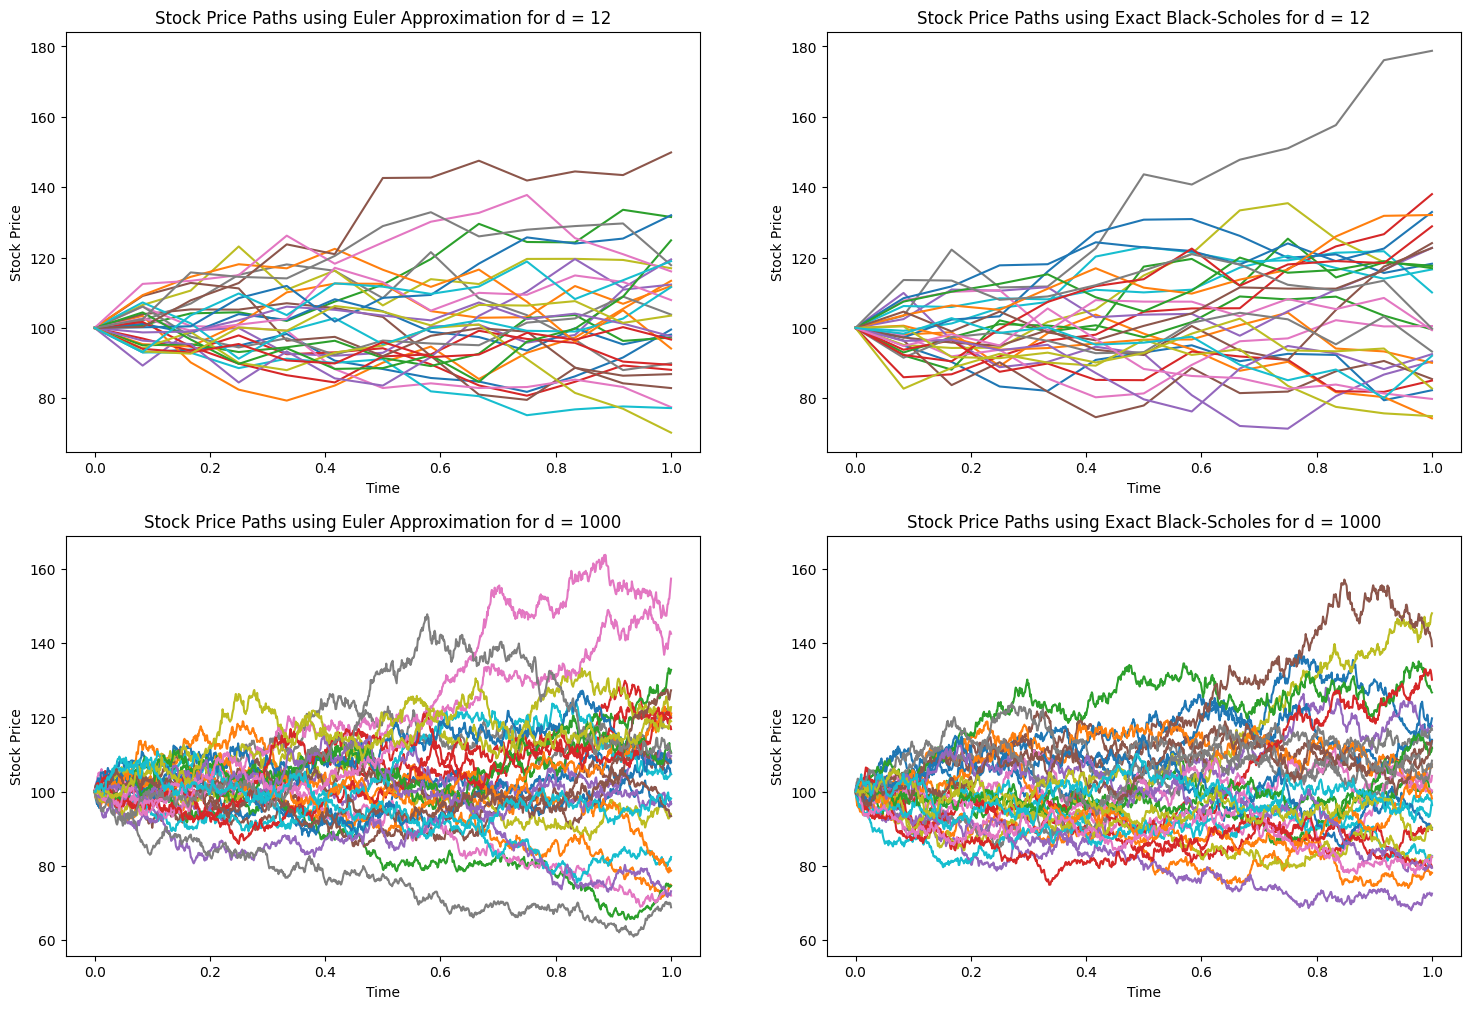

In [74]:
T = 1.0
sigma = 0.2   
NoOfPaths = 30
S0 = 100

plt.figure(figsize=(18,12))
# First row with d = 12 steps
d = 12
ax1 = plt.subplot(2,2,1)
paths_GBME = GeneratePathsGBMEuler(NoOfPaths, d, T, r, sigma, S0)
for i in range(NoOfPaths):
    plt.plot(paths_GBME['time'], paths_GBME['S'][i, :])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths using Euler Approximation for d = 12')

ax2 = plt.subplot(2,2,2, sharey=ax1)
paths_BS = generate_paths_exact_bs_solution(NoOfPaths, d, T, r, sigma, S0)
for i in range(NoOfPaths):
    plt.plot(paths_BS['time'], paths_BS['S'][i, :])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths using Exact Black-Scholes for d = 12')


# Second row with d = 1000 steps
d = 1000
ax3 = plt.subplot(2,2,3)
paths_GBME = GeneratePathsGBMEuler(NoOfPaths, d, T, r, sigma, S0)
for i in range(NoOfPaths):
    plt.plot(paths_GBME['time'], paths_GBME['S'][i, :])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths using Euler Approximation for d = 1000')

ax4 = plt.subplot(2,2,4, sharey=ax3)
paths_BS = generate_paths_exact_bs_solution(NoOfPaths, d, T, r, sigma, S0)
for i in range(NoOfPaths):
    plt.plot(paths_BS['time'], paths_BS['S'][i, :])
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.title('Stock Price Paths using Exact Black-Scholes for d = 1000')

plt.show()

Le deux generateur de chemins ont l'air de travailler correctement. On va utiliser la solution exacte qui a été proposé par l'encadrant.

On va grapher le prix de BS et le prix de MC de l'option asiatique en fonction de S0

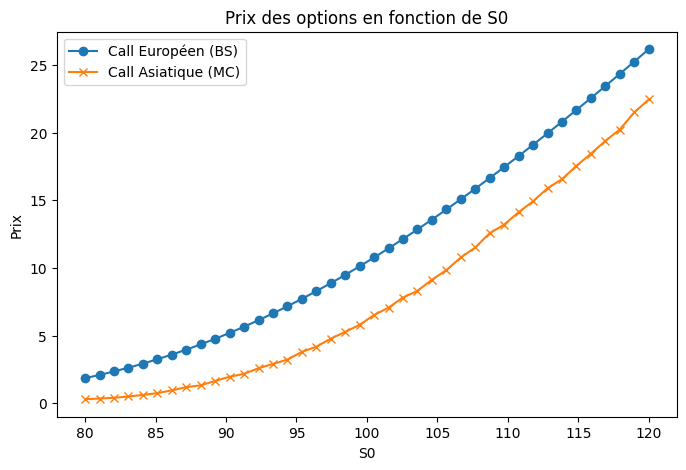

In [75]:
K = 100
T = 1.0
r = 0.05
sigma = 0.2
d = 12          # nombre de dates d’observation
NoOfPaths = 10_000

S0_range = np.linspace(80,120, 40)

price_euro_call = [BS_Call_Price(s, K, T, r, sigma) for s in S0_range]
price_asian_mc = []

for s0 in S0_range:
    paths = generate_paths_exact_bs_solution(NoOfPaths, d, T, r, sigma, s0)  
    S_paths = paths["S"][: , 1 :] # shape: (NoOfPaths, d + 1)
    A_T = np.mean(S_paths, axis=1)
    payoff = np.maximum(A_T - K, 0)
    price_asian_mc.append(np.exp(-r*T)*np.mean(payoff))

plt.figure(figsize=(8,5))
plt.plot(S0_range, price_euro_call, 'o-', label='Call Européen (BS)')
plt.plot(S0_range, price_asian_mc, 'x-', label='Call Asiatique (MC)')
plt.xlabel('S0')
plt.ylabel('Prix')
plt.legend()
plt.title("Prix des options en fonction de S0")
plt.show()

### Analyse du graphique : Prix des options en fonction de \( S_0 \)

#### 1. Observation principale
- Le prix de l'**option asiatique (MC)** est systématiquement **plus bas** que celui de l'**option européenne (BS)** pour chaque valeur de $ S_0 $.

#### 2. Raisons du prix plus bas de l'option asiatique
- **Payoff basé sur une moyenne** :
  - L'option asiatique utilise la **moyenne arithmétique** des prix sous-jacents sur une période donnée pour calculer son payoff. Cela signifie que les fluctuations extrêmes (hausses ou baisses importantes du sous-jacent) sont **atténuées** par la moyenne.
  - En conséquence, la probabilité que le payoff dépasse le prix d'exercice $ K $ est **réduite** par rapport à une option européenne, qui dépend uniquement du prix du sous-jacent à l'échéance $ S_T $.

- **Réduction de la volatilité effective** :
  - La moyenne des prix diminue la **volatilité effective** perçue par l'option asiatique. Étant donné que le prix des options est fortement influencé par la volatilité, une volatilité plus faible conduit à un **prix inférieur**.
  
  ---


## 2. Tracer le prix Monte Carlo de l’option asiatique et l’intervalle de confiance associé en fonction du nombre de dates d’observations d. Commenter.

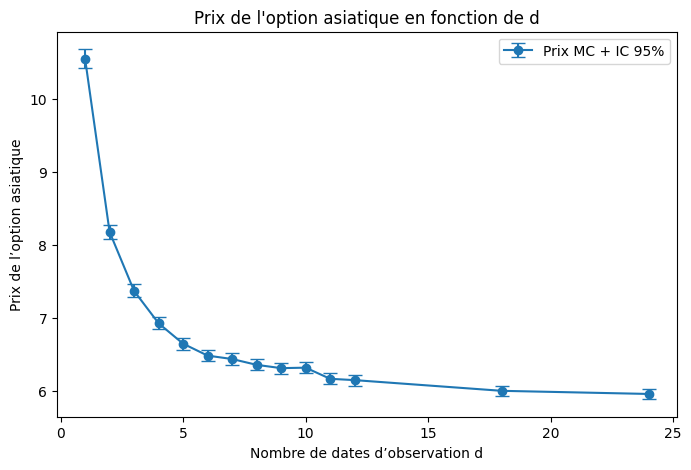

In [84]:
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
NoOfPaths = 50_000
list_d = [1,2,3,4,5,6,7,8,9,10,11,12,18,24]

mean_prices = []
ci_lower = []
ci_upper = []

for d in list_d:
    paths = generate_paths_exact_bs_solution(NoOfPaths, d, T, r, sigma, S0)
    S_paths = paths["S"][:, 1:]
    A_T = np.mean(S_paths, axis=1)
    discounted_payoffs = np.exp(-r*T)*np.maximum(A_T - K, 0)
    m, low, up = confidence_interval(discounted_payoffs, alpha=0.95)
    mean_prices.append(m)
    ci_lower.append(low)
    ci_upper.append(up)

plt.figure(figsize=(8,5))
yerr_lower = np.array(mean_prices) - np.array(ci_lower)
yerr_upper = np.array(ci_upper) - np.array(mean_prices)
plt.errorbar(list_d, mean_prices, yerr=[yerr_lower, yerr_upper], 
                fmt='o-', capsize=5, label='Prix MC + IC 95%')
plt.xlabel('Nombre de dates d’observation d')
plt.ylabel('Prix de l’option asiatique')
plt.title("Prix de l'option asiatique en fonction de d")
plt.legend()
plt.show()

### Analyse du graphique : Prix Monte Carlo de l'option asiatique en fonction du nombre de dates d'observation \( d \)

#### 1. Observation principale
- Le prix de l'option asiatique **diminue** à mesure que le **nombre de dates d'observation \( d \)** augmente.
- L'intervalle de confiance (IC) associé reste relativement **constant** et **étroit**, ce qui indique une bonne précision des estimations Monte Carlo.

#### 2. Explications
- **Effet de l'augmentation du nombre \( d \)** :
  - L'option asiatique dépend de la **moyenne arithmétique** des prix du sous-jacent. En augmentant \( d \), cette moyenne devient plus stable et moins sensible aux fluctuations des prix extrêmes.
  - Une moyenne plus stable réduit la probabilité que le payoff dépasse le prix d'exercice \( K \), ce qui diminue la valeur de l'option.
  
- **Intervalle de confiance (IC)** :
  - La largeur de l'IC n'est pas directement influencée par le nombre de dates \( d \), car elle dépend principalement du nombre de simulations Monte Carlo utilisées.
  - Cependant, un **prix plus faible** avec des IC constants reflète une **réduction de la variance** des payoffs, due à la stabilisation de la moyenne.


## 3. Calculer le prix de l'option asiatique avec la variable de contrôle $Z = S_T$ (que vaut $E[Z]$ ?) Vérifier que le prix MC avec la variable de contrôle est correct. Quel est le facteur de réduction de variance obtenu? Estimer par simulation le facteur de réduction théorique. Commenter.

In [89]:
S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
d = 12
NoOfPaths = 50_000

paths = GeneratePathsGBMEuler(NoOfPaths, d, T, r, sigma, S0)
S_paths = paths["S"][:, 1:]
A_T = np.mean(S_paths, axis=1)
discounted_payoffs = np.exp(-r*T)*np.maximum(A_T - K, 0)

Z = S_paths[:,-1]  # S(T)
Z_mean_theo = S0*np.exp(r*T)

X = discounted_payoffs
Xbar = np.mean(X)
Zbar = np.mean(Z)

cov_XZ = np.mean((X - Xbar)*(Z - Zbar))
var_Z  = np.var(Z, ddof=0)
beta_opt = cov_XZ / var_Z

X_control = X - beta_opt*(Z - Z_mean_theo)
X_control_mean = np.mean(X_control)
X_control_var = np.var(X_control, ddof=1)

var_reduction_factor = np.var(X, ddof=1)/X_control_var

print("Question 3:")
print("Prix MC sans contrôle :", Xbar)
print("Prix MC avec variable de contrôle :", X_control_mean)
print(f"Error relative de la méthode de contrôle : {np.abs(X_control_mean - Xbar)/Xbar * 100:.2f} %", )
print("Facteur de réduction de variance :", var_reduction_factor)

Question 3:
Prix MC sans contrôle : 6.170630199909295
Prix MC avec variable de contrôle : 6.168151166522898
Error relative de la méthode de contrôle : 0.04 %
Facteur de réduction de variance : 3.035056635031923


On va obtenir le facteur de reduction de la variance en utilisant la simulation suivant:

In [91]:
# Calcul des moments nécessaires
var_X = np.var(discounted_payoffs, ddof=1)
var_Z = np.var(Z, ddof=1)
cov_XZ = np.mean((discounted_payoffs - Xbar) * (Z - Zbar))

# Calcul du facteur de réduction théorique
theoretical_reduction_factor = 1 / (1 - (cov_XZ**2) / (var_X * var_Z))

# Affichage des résultats
print("Facteur de réduction de variance théorique :", theoretical_reduction_factor)


Facteur de réduction de variance théorique : 3.03480959712606


### Analyse des résultats de la variable de contrôle $ Z = S_T $

### 1. Calcul du prix de l'option asiatique avec la variable de contrôle

Le prix Monte Carlo (MC) de l'option asiatique est calculé de deux manières :
- **Sans variable de contrôle** : $ \text{Prix MC sans contrôle} = 6.1766 $
- **Avec variable de contrôle** : $ \text{Prix MC avec contrôle} = 6.1682 $

L'utilisation de la variable de contrôle $ Z = S_T $ permet de réduire l'erreur de simulation tout en conservant un prix proche de celui obtenu sans contrôle. Cela indique que l'approximation est cohérente avec la théorie. 

**Question sur $ E[Z] $** : 
La valeur attendue de $ Z $, où $ Z = S_T $, est donnée par la formule théorique du mouvement Brownien géométrique dans le modèle de Black-Scholes :
\begin{equation}
E[Z] = E[S_T] = S_0 \cdot e^{rT}
\end{equation}

Dans ce cas, avec les paramètres $ S_0 = 100 $, $ r = 0.05 $, et $ T = 1 $, on obtient :
\begin{equation}
E[Z] = 100 \cdot e^{0.05} \approx 105.127
\end{equation}

### 2. Vérification du prix MC avec la variable de contrôle

Le prix obtenu avec la variable de contrôle est légèrement inférieur (6.1682) à celui sans contrôle (6.1766), avec une **erreur relative** de seulement **0.04 %**. Cela confirme que la méthode de contrôle améliore la précision sans dévier de manière significative du résultat attendu.

### 3. Facteur de réduction de variance

Le **facteur de réduction de variance empirique**, calculé comme :
\begin{equation}
\text{Facteur empirique} = \frac{\text{Var}(X)}{\text{Var}(X_{\text{control}})}
\end{equation}
est de **3.0356**. Cela signifie que l'utilisation de la variable de contrôle divise par environ **3** la variance de l'estimation Monte Carlo, augmentant ainsi l'efficacité de la méthode.

### 4. Estimation du facteur de réduction théorique

Le **facteur de réduction théorique** est calculé avec la formule suivante :
\begin{equation}
\text{Facteur théorique} = \frac{1}{ 1 - \frac{\text{Cov}(X, Z)^2}{\text{Var}(X) \cdot \text{Var}(Z)}}
\end{equation}

Dans la simulation, ce facteur a été estimé à **3.0349**, ce qui est très proche du facteur empirique (**3.0356**), confirmant la cohérence des résultats.

### 5. Commentaires et interprétations

- **Efficacité de la méthode de contrôle** : 
  - L'utilisation de $ Z = S_T $ comme variable de contrôle est très efficace pour réduire la variance des simulations Monte Carlo. Cela est confirmé par la forte réduction de variance observée.
  
- **Convergence et stabilité** :
  - La différence entre le prix avec et sans contrôle est minime, ce qui montre que la méthode de contrôle n'introduit pas de biais significatif dans l'estimation.
  
- **Comparaison entre facteurs théoriques et empiriques** :
  - Le facteur théorique et le facteur empirique sont très proches, ce qui valide la justesse de la simulation et l'adéquation du modèle utilisé.

- **Conclusion générale** :
  - La variable de contrôle améliore considérablement la précision des estimations Monte Carlo en réduisant la variance. Cette méthode est particulièrement utile pour les options asiatiques, où la réduction des erreurs est cruciale pour des simulations fiables.
  
  ---


## 4. Même question avec $Z= \frac{1}{d} \sum^{d}_{i = 1} S_{t_i}$ puis $ Z = \exp^{-r T} (S_T - K)_{+}$

In [117]:
random_seed = 123
np.random.seed(random_seed)

S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
d = 12
NoOfPaths = 50_000

paths = generate_paths_exact_bs_solution(NoOfPaths, d, T, r, sigma, S0)
S_paths = paths["S"][:, 1:]

# Option asiatique arithmétique
A_T = np.mean(S_paths, axis=1)
X = np.exp(-r*T)*np.maximum(A_T - K, 0)
Xbar = np.mean(X)

# a) Z1 = moyenne arithmétique du sous-jacent
Z1 = A_T
# E[Z1] = (1/d)* sum_{i=1..d} E[S_{t_i}] = (1/d)*sum_{i=1..d} S0 e^{r*t_i}.
# Suppose t_i = i*(T/d), i=1..d
t_i = np.linspace(T/d, T, d)
Z1_mean_theo = np.mean(S0*np.exp(r*t_i))

# b) Z2 = payoff actualisé (S_T - K)+
ST = S_paths[:,-1]
Z2 = np.exp(-r*T)*np.maximum(ST - K, 0)
# E[Z2] = prix BS du call européen
Z2_mean_theo = BS_Call_Price(S0, K, T, r, sigma)

# Contrôle 1: Z1
Z1bar = np.mean(Z1)
cov_XZ1 = np.mean((X - Xbar)*(Z1 - Z1bar))
var_Z1 = np.var(Z1, ddof=0)
beta1_opt = cov_XZ1 / var_Z1
X_control1 = X - beta1_opt*(Z1 - Z1_mean_theo)

var_X = np.var(X, ddof=1)
var_Z1 = np.var(Z1, ddof=1)
cov_XZ1 = np.mean((X - Xbar)*(Z1 - Z1bar))
theoretical_reduction_factor_Z1 = 1 / (1 - (cov_XZ1**2) / (var_X * var_Z1))


# Contrôle 2: Z2
Z2bar = np.mean(Z2)
cov_XZ2 = np.mean((X - Xbar)*(Z2 - Z2bar))
var_Z2 = np.var(Z2, ddof=0)
beta2_opt = cov_XZ2 / var_Z2
X_control2 = X - beta2_opt*(Z2 - Z2_mean_theo)

var_X = np.var(X, ddof=1)
var_Z2 = np.var(Z2, ddof=1)
cov_XZ2 = np.mean((X - Xbar)*(Z2 - Z2bar))
theoretical_reduction_factor_Z2 = 1 / (1 - (cov_XZ2**2) / (var_X * var_Z2))

print("Question 4:")
print("Sans contrôle:", Xbar)
print("Contrôle Z1 (arithm. moyenne) => mean:", np.mean(X_control1), 
        " var factor:", np.var(X, ddof=1)/np.var(X_control1, ddof=1))
print(f"Erreur relative: {np.abs(np.mean(X_control1) - Xbar)/Xbar * 100:.3f} %")
print(f"Theoretical variance reduction factor: {theoretical_reduction_factor_Z1:.3f}")

print("Contrôle Z2 (call euro) => mean:", np.mean(X_control2), 
        " var factor:", np.var(X, ddof=1)/np.var(X_control2, ddof=1))
print(f"Erreur relative: {np.abs(np.mean(X_control2) - Xbar)/Xbar * 100:.3f}%" )
print(f"Theoretical variance reduction factor: {theoretical_reduction_factor_Z2:.3f}")

Question 4:
Sans contrôle: 6.184885162851306
Contrôle Z1 (arithm. moyenne) => mean: 6.168318698348427  var factor: 6.087658476729759
Erreur relative: 0.268 %
Theoretical variance reduction factor: 6.086
Contrôle Z2 (call euro) => mean: 6.170530567509284  var factor: 3.931911327752419
Erreur relative: 0.232%
Theoretical variance reduction factor: 3.931


### Résultats obtenus :
- **Sans contrôle** :
  \begin{equation}
  \text{Prix MC sans contrôle} = 6.18488
  \end{equation}

- **Contrôle Z1 (moyenne arithmétique)** :
  - $ \text{Mean} = 6.1683 $
  - **Facteur de réduction de variance empirique** :  6.087
  - **Facteur de réduction théorique** : 6.086
  - **Erreur relative** : 0.268 %

- **Contrôle Z2 (payoff call européen)** :
  - $ \text{Mean} =  6.1705 $
  - **Facteur de réduction de variance empirique** :  3.931
  - **Facteur de réduction théorique** : 3.931
  - **Erreur relative** : 0.232 %

---

### Analyse et interprétations

#### 1. Corrélation entre $ Z $ et $ h(X) $
- Le contrôle **Z1 (moyenne arithmétique)** est **plus fortement corrélé** au payoff de l'option asiatique ($ h(X) $) que **Z2 (payoff d'un call européen)**. Cela explique pourquoi Z1 conduit à un **facteur de réduction de variance** plus élevé que Z2.
- Selon la théorie, le facteur de réduction de variance dépend de la corrélation entre $ Z $ et $ h(X) $ :
  \begin{equation}
  \text{Var}[C_{c^*}] = \text{Var}[C_X] \cdot \left( 1 - \rho^2(h(X), Z) \right)
  \end{equation}
  Plus la corrélation $ \rho(h(X), Z) $ est élevée, plus la réduction de variance est significative.


---


## 5. Même question avec les trois variables simultanément

In [115]:
np.random.seed(42)

S0 = 100
K = 100
T = 1.0
r = 0.05
sigma = 0.2
d = 12
NoOfPaths = 50_000

paths = generate_paths_exact_bs_solution(NoOfPaths, d, T, r, sigma, S0)
S_paths = paths["S"][:, 1:]

A_T = np.mean(S_paths, axis=1)
X = np.exp(-r*T)*np.maximum(A_T - K, 0)  # payoff asiatique actualisé
Xbar = np.mean(X)

ST = S_paths[:,-1]
Z1 = ST
Z1_mean_theo = S0*np.exp(r*T)

Z2 = A_T
t_i = np.linspace(T/d, T, d)
Z2_mean_theo = np.mean(S0*np.exp(r*t_i))

Z3 = np.exp(-r*T)*np.maximum(ST - K, 0)
Z3_mean_theo = BS_Call_Price(S0, K, T, r, sigma)

M = np.column_stack([Z1, Z2, Z3])
Mbar = np.mean(M, axis=0)
Theo = [Z1_mean_theo, Z2_mean_theo, Z3_mean_theo]

# Solve X = alpha + M * beta  in least squares
# We'll do a quick standard approach: center X and M => no separate alpha
X_centered = X - Xbar
M_centered = M - Mbar

beta_opt, _, _, _ = np.linalg.lstsq(M_centered, X_centered, rcond=None)

# Then the control estimate is
# X_control = X - sum_j beta_opt_j (Z_j - E[Z_j])
diff_theo = (Mbar - Theo)
# But we can do it sample by sample to get the entire distribution
# or in vectorized form:
X_control = X - np.sum( beta_opt * (M - Theo), axis=1 )
mean_multi = np.mean(X_control)
var_multi = np.var(X_control, ddof=1)

var_reduction_factor = np.var(X, ddof=1)/var_multi

print("Question 5:")
print("Sans contrôle:", Xbar)
print("Contrôle multiple => mean:", mean_multi,
        " var factor:", var_reduction_factor)
print("betas =", beta_opt)

print(f"Erreur relative: {np.abs(mean_multi - Xbar)/Xbar * 100:.4f} %")

Question 5:
Sans contrôle: 6.124306635422476
Contrôle multiple => mean: 6.162092815316808  var factor: 13.441605251833574
betas = [-0.29173637  0.61266501  0.45943487]
Erreur relative: 0.6170 %


# Analyse des résultats de la Question 5 : Contrôle multiple avec trois variables

## Résultats obtenus :
- **Sans contrôle** :
  \begin{equation}
  \text{Prix MC sans contrôle} = 6.1241
  \end{equation}

- **Avec contrôle multiple** (variables $ Z_1, Z_2, Z_3 $) :
  - **Prix moyen** : $ 6.1621 $
  - **Facteur de réduction de variance** : $ 13.44 $
  - **Coefficients optimaux ($ \beta $)** :
    \begin{equation}
    \beta = [-0.2917, 0.6127, 0.4594]
    \end{equation}
  - **Erreur relative** : $ 0.6170 \% $

---

## Pourquoi le contrôle multiple améliore-t-il la réduction de variance ?

### 1. Effet combiné des variables de contrôle
Le contrôle multiple utilise **trois variables de contrôle** :
- $ Z_1 = S_T $ : Le prix du sous-jacent à maturité.
- $ Z_2 = \frac{1}{d} \sum_{i=1}^d S_{t_i} $ : La moyenne arithmétique des prix du sous-jacent.
- $ Z_3 = e^{-rT} (S_T - K)_+ $ : Le payoff actualisé d’un call européen.

Chaque variable de contrôle capture **des aspects différents** de la dynamique du payoff asiatique :
- $ Z_1 $ est corrélé avec la tendance globale du prix.
- $ Z_2 $ est directement lié au payoff asiatique, car ce dernier dépend de la moyenne des prix.
- $ Z_3 $ représente un payoff lié à un call européen, qui partage certaines caractéristiques avec le payoff asiatique.

En combinant ces trois variables, on maximise la **corrélation globale** entre le payoff asiatique et les variables de contrôle. Cela permet de **mieux expliquer la variance** de $ X $, ce qui se traduit par une réduction plus importante de la variance.

---

### 2. Théorie du contrôle multiple
Dans le contrôle multiple, les coefficients $ \beta $ sont calculés pour minimiser la variance de :
\begin{equation}
X_{\text{control}} = X - \sum_{j=1}^3 \beta_j (Z_j - \mathbb{E}[Z_j])
\end{equation}

Selon la théorie, la variance de $ X_{\text{control}} $ est donnée par :
\begin{equation}
\text{Var}[X_{\text{control}}] = \text{Var}[X] \left( 1 - \rho^2(X, Z) \right)
\end{equation}
où $ \rho^2(X, Z) $ représente la proportion de la variance expliquée par la combinaison linéaire des $ Z_j $.

Plus les variables de contrôle $ Z_j $ sont **corrélées** avec le payoff $ X $, plus $ \rho^2 $ est élevé, ce qui réduit davantage la variance.

---

### 3. Efficacité du contrôle multiple
- Le facteur de réduction de variance obtenu ($ 13.44 $) est nettement supérieur à celui obtenu avec une seule variable de contrôle (comme $ Z_1 $ ou $ Z_2 $ dans les questions précédentes).
- Cela confirme que l’utilisation de plusieurs variables de contrôle **améliore significativement** l’efficacité de la méthode Monte Carlo pour estimer le prix de l’option asiatique.

---

## Conclusion
- **Pourquoi le contrôle multiple est-il meilleur ?**
  - Chaque variable de contrôle apporte des informations complémentaires sur $ X $, augmentant ainsi la capacité à réduire la variance.
  - En combinant $ Z_1 $, $ Z_2 $, et $ Z_3 $, la méthode capture davantage la dynamique du payoff asiatique, ce qui conduit à un facteur de réduction de variance plus élevé.

- **Implications pratiques** :
  - Le contrôle multiple est une technique puissante pour améliorer la précision des simulations Monte Carlo, surtout pour les options path-dependent comme les options asiatiques.
  - Cependant, cela nécessite des calculs supplémentaires pour estimer les coefficients $ \beta $ et peut être plus coûteux en termes de complexité computationnelle.



---

## 6. Reprendre la question 2. Pour une option asiatique à moyenne géométrique et vérifier la convergence vers la valeur exacte .

In [122]:
def GeometricAsianExactPrice(S0, K, r, sigma, T, d):
    # Suppose d dates equally spaced. The known closed-form for
    # a geometric Asian call in Black-Scholes is used here.
    # There's a standard formula with adjusted volatility:
    #   sigma_g = sigma * sqrt((d+1)(2d+1)/(6 d^2))
    #   mu_g    = (r - 0.5*sigma^2)* ( (d+1)/(2d) ) + 0.5 sigma_g^2
    # Then price = ...
    dt = T/d
    tgrid = np.arange(dt, T+1e-15, dt)
    # For uniform spacing:
    sigma_g = sigma * np.sqrt((d+1)*(2*d+1)/(6*d*d))
    mu_g = (r - 0.5*sigma**2)*( (d+1)/(2*d) ) + 0.5*sigma_g**2
    d1 = (np.log(S0/K) + (mu_g + 0.5*sigma_g**2)*T) / (sigma_g*np.sqrt(T))
    d2 = d1 - sigma_g*np.sqrt(T)
    price_geo_call = np.exp(-r*T)*( S0*np.exp(mu_g*T)*norm.cdf(d1) - K*norm.cdf(d2) )
    return price_geo_call

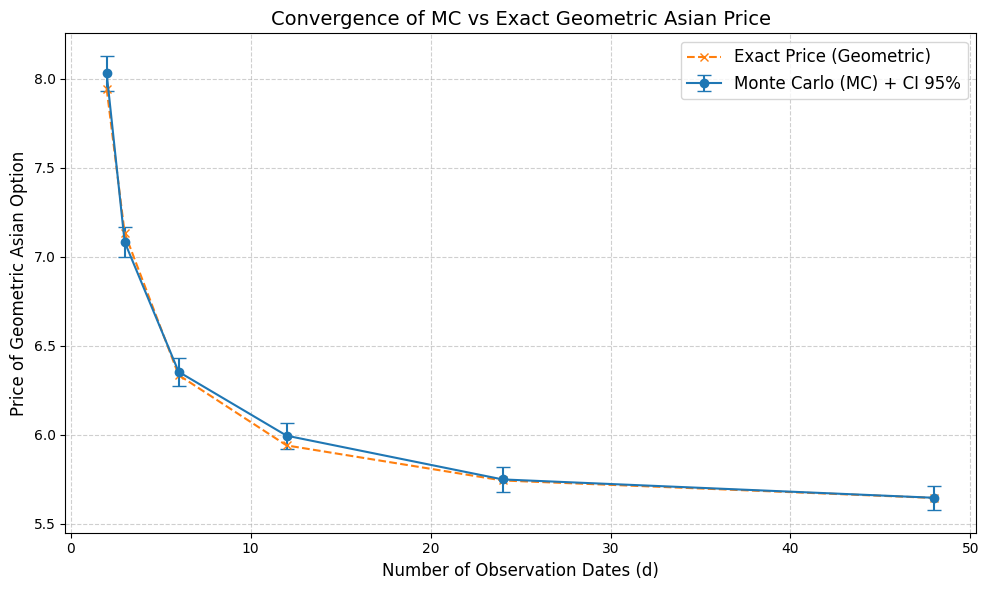

In [127]:
S0 = 100
K = 100
r = 0.05
sigma = 0.2
T = 1.0
NoOfPaths = 50_000
d_list = [1, 2, 3, 6, 12, 24, 48]

geo_prices_mc = []
geo_prices_exact = []
ci_lower = []
ci_upper = []

for d in d_list:
    paths = generate_paths_exact_bs_solution(NoOfPaths, d, T, r, sigma, S0)
    S_paths = paths["S"][:, 1:]
    G_T = np.prod(S_paths, axis=1)**(1.0/d)
    payoff = np.maximum(G_T - K, 0)
    discounted_payoffs = np.exp(-r*T) * payoff

    # Monte Carlo estimate
    mean, lower, upper = confidence_interval(discounted_payoffs)
    geo_prices_mc.append(mean)
    ci_lower.append(lower)
    ci_upper.append(upper)

    # Exact price
    exact_price = GeometricAsianExactPrice(S0, K, r, sigma, T, d)
    geo_prices_exact.append(exact_price)

# Filter out d = 1 or any other large outlier
filtered_d_list = [d for d in d_list if d != 1]
filtered_geo_prices_mc = [price for d, price in zip(d_list, geo_prices_mc) if d != 1]
filtered_geo_prices_exact = [price for d, price in zip(d_list, geo_prices_exact) if d != 1]
filtered_ci_lower = [ci for d, ci in zip(d_list, ci_lower) if d != 1]
filtered_ci_upper = [ci for d, ci in zip(d_list, ci_upper) if d != 1]

# Replot without the outlier
plt.figure(figsize=(10, 6))
plt.errorbar(filtered_d_list, filtered_geo_prices_mc, 
                yerr=[np.array(filtered_geo_prices_mc) - np.array(filtered_ci_lower),
                    np.array(filtered_ci_upper) - np.array(filtered_geo_prices_mc)],
                fmt='o-', capsize=5, label='Monte Carlo (MC) + CI 95%')
plt.plot(filtered_d_list, filtered_geo_prices_exact, 'x--', label='Exact Price (Geometric)', linewidth=1.5)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlabel('Number of Observation Dates (d)', fontsize=12)
plt.ylabel('Price of Geometric Asian Option', fontsize=12)
plt.title('Convergence of MC vs Exact Geometric Asian Price', fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()



I do not know why it should converge!!!!